### Import all necessary libraries

In [37]:
#!pip install seaborn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import sklearn
import nltk.collocations 
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import string, re
import urllib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#nltk.download('punkt')
#nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Read CSV Data

In [38]:
song_list = pd.read_csv('380lyrics.csv')
charts = pd.read_csv('chart.csv')

### Remove Rows with Other and Not Available Genre

In [39]:
song_list.genre.value_counts()

Rock             131377
Pop               49444
Hip-Hop           33965
Not Available     29814
Metal             28408
Other             23683
Country           17286
Jazz              17147
Electronic        16205
R&B                5935
Indie              5732
Folk               3241
Name: genre, dtype: int64

In [40]:
song_list.drop(song_list[song_list.genre == "Other"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Not Available"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Indie"].index, inplace = True)
song_list.drop(song_list[song_list.genre == "Folk"].index, inplace = True)
song_list.drop(song_list[song_list.artist == "dolcenera"].index, inplace = True)
song_list.drop(song_list[song_list.artist == "brthhse-onkelz"].index, inplace = True)
song_list.shape

(299523, 6)

In [41]:
song_list.tail()

,index,song,year,artist,genre,lyrics
362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...
362236,362236,amen,2012,edens-edge,Country,I heard from a friend of a friend of a friend ...


### Drop rows with NAN values for column song

In [42]:
song_list.dropna(inplace = True)
song_list.song.isna().sum()
song_list.reset_index(inplace = True)

In [43]:
song_list.tail()

,level_0,index,song,year,artist,genre,lyrics
231786,362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
231787,362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
231788,362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
231789,362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...
231790,362236,362236,amen,2012,edens-edge,Country,I heard from a friend of a friend of a friend ...


### Clean Song titles to remove dashes and capitalize

In [44]:
def clean_song_names(titles_list):
    no_dot = list(map(lambda item: item.replace(".", ""), titles_list))
    no_dash = list(map(lambda item: item.replace("-", " "), no_dot))
    return list(map(lambda item: string.capwords(item), no_dash))

titles_list = song_list.song
final_titles = clean_song_names(titles_list)
len(final_titles)

231791

### Append Clean Song names to DF as a new column and drop old column

In [45]:
new_df = song_list
# new_df.head()
new_titles = final_titles


new_lyr = pd.DataFrame(new_titles)
new_lyr.tail()

final_df = new_df.join(new_lyr)

final_df.drop(columns = ['song', 'level_0', "index"], axis = 1, inplace = True)


In [46]:
final_df.shape

(231791, 5)

In [47]:
final_df.rename(columns = {0: "song"}, inplace = True)
final_df.isna().sum()

year      0
artist    0
genre     0
lyrics    0
song      0
dtype: int64

In [48]:
final_df.shape

(231791, 5)

### Drop Song titles with Nan Values

In [49]:
final_df.genre.value_counts()

Rock          108992
Pop            40466
Hip-Hop        24850
Metal          23759
Country        14387
Jazz            7970
Electronic      7966
R&B             3401
Name: genre, dtype: int64

In [50]:
rock_df = final_df[final_df.genre == "Rock"][-900:]
pop_df = final_df[final_df.genre == "Pop"][:900]
hip_df = final_df[final_df.genre == "Hip-Hop"][:900]
metal_df = final_df[final_df.genre == "Metal"][:900]
jazz_df = final_df[final_df.genre == "Jazz"][:900]
elec_df = final_df[final_df.genre == "Electronic"][:900]
country_df = final_df[final_df.genre == "Country"][:900]
rnb_df = final_df[final_df.genre == "R&B"][:900]


In [51]:
rock_df.head()

,year,artist,genre,lyrics,song
228781,2006,brainstorm,Rock,Good morning my goodness and majesty!\nGood mo...,Space Detective Story
228782,2006,brainstorm,Rock,Got a cheesy poem in my head\nTom Jones is my ...,These Women Drive Me Crazy All The Time
228783,2006,brainstorm,Rock,If only I could trace that light\nTo ignore th...,Behind
228784,2006,brainstorm,Rock,I've never thought about if I do love you\nIt'...,Before The Time Has Come To Leave You
228785,2006,brainstorm,Rock,My friends gonna call me: hey dreamer\nThe sta...,My Star


In [52]:
final_df.drop(final_df[final_df.genre == "Rock"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Pop"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Hip-Hop"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Metal"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Jazz"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Electronic"].index, inplace = True)
final_df.drop(final_df[final_df.genre == "Country"].index, inplace = True)


In [53]:
maybe_df = final_df.append([rock_df, pop_df, hip_df, metal_df, jazz_df, elec_df, country_df])
maybe_df.genre.value_counts()

R&B           3401
Hip-Hop        900
Metal          900
Country        900
Jazz           900
Rock           900
Pop            900
Electronic     900
Name: genre, dtype: int64

In [54]:
maybe_df.drop(maybe_df[maybe_df.genre == "R&B"].index, inplace = True)
maybe_df = maybe_df.append([rnb_df])

In [55]:
maybe_df.genre.value_counts()

Hip-Hop       900
Metal         900
Country       900
Jazz          900
R&B           900
Rock          900
Pop           900
Electronic    900
Name: genre, dtype: int64

In [56]:
maybe_df.reset_index(inplace = True)

In [57]:
maybe_df.drop(columns = ["index"], axis = 1, inplace = True)

In [58]:
maybe_df.head()

,year,artist,genre,lyrics,song
0,2006,brainstorm,Rock,Good morning my goodness and majesty!\nGood mo...,Space Detective Story
1,2006,brainstorm,Rock,Got a cheesy poem in my head\nTom Jones is my ...,These Women Drive Me Crazy All The Time
2,2006,brainstorm,Rock,If only I could trace that light\nTo ignore th...,Behind
3,2006,brainstorm,Rock,I've never thought about if I do love you\nIt'...,Before The Time Has Come To Leave You
4,2006,brainstorm,Rock,My friends gonna call me: hey dreamer\nThe sta...,My Star


In [59]:
lyrics_list = list(maybe_df.lyrics)

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
english = list(set(nltk.corpus.words.words()))

def clean_docs_lemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

def clean_docs_stemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_stemmas)
        cleaned.append(c)
    return cleaned

### First thing we wanted to do is test whether Lemmatizing works better than Stemmatizing

### Stemmed Lyrics Test

In [60]:
stemmed_lyrics = clean_docs_stemma(lyrics_list)


In [61]:
len(set(nltk.word_tokenize(" ".join(stemmed_lyrics))))

29945

In [62]:
X = stemmed_lyrics
y = maybe_df.genre

len(X) == len(y)

True

In [63]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(stemmed_lyrics, maybe_df.genre, test_size=0.2, random_state=18)

In [64]:

pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

pipe_ADA = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', AdaBoostClassifier(learning_rate=0.3))
                    ])


pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

# List of pipelines, List of pipeline names
pipelines = [pipe_NB, pipe_GBoost, pipe_RF, pipe_ADA, pipe_KNN]
pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest', 'ADA', "KNN"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)

# Compare accuracies
basic_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X_test, y_test))
    basic_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dty

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...m='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=50, random_state=None))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])
Multinomail NB pipeline test accuracy: 0.452
Gboost pipeline test accuracy: 0.453
Random Forest pipeline test accuracy: 0.408
ADA pipeli

<BarContainer object of 5 artists>

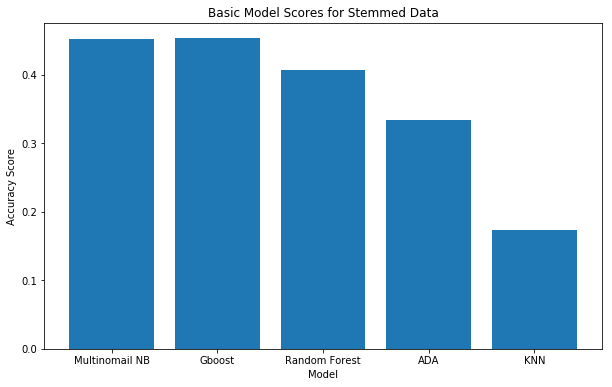

In [73]:
modles_stem = [item[0] for item in basic_scores]
accuracy_stem = [item[1] for item in basic_scores]

plt.figure(figsize=(10,6))
plt.title("Basic Model Scores for Stemmed Data")
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.bar(modles_stem, accuracy_stem)

### Lemmed Lyrics Test

In [74]:
lemmed_lyrics = clean_docs_lemma(lyrics_list)

In [75]:
len(set(lemmed_lyrics))

6741

In [76]:
X = lemmed_lyrics
y = maybe_df.genre



In [77]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(lemmed_lyrics, maybe_df.genre, test_size=0.2, random_state=18) 

In [78]:
pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

pipe_GBoost = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])

pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

pipe_ADA = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', AdaBoostClassifier(learning_rate=0.3))
                    ])


pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

# List of pipelines, List of pipeline names
pipelines = [pipe_NB, pipe_GBoost, pipe_RF, pipe_ADA, pipe_KNN]
pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest', 'ADA', "KNN"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)

# Compare accuracies
lemmed_basic_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X_test, y_test))
    lemmed_basic_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dty

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...m='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=50, random_state=None))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
 ...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])
Multinomail NB pipeline test accuracy: 0.457
Gboost pipeline test accuracy: 0.449
Random Forest pipeline test accuracy: 0.401
ADA pipeli

In [79]:
lemmed_basic_scores

[('Multinomail NB', 0.45694444444444443),
 ('Gboost', 0.4486111111111111),
 ('Random Forest', 0.40069444444444446),
 ('ADA', 0.3423611111111111),
 ('KNN', 0.17916666666666667)]

In [80]:
basic_scores

[('Multinomail NB', 0.45208333333333334),
 ('Gboost', 0.4534722222222222),
 ('Random Forest', 0.4076388888888889),
 ('ADA', 0.3333333333333333),
 ('KNN', 0.17291666666666666)]

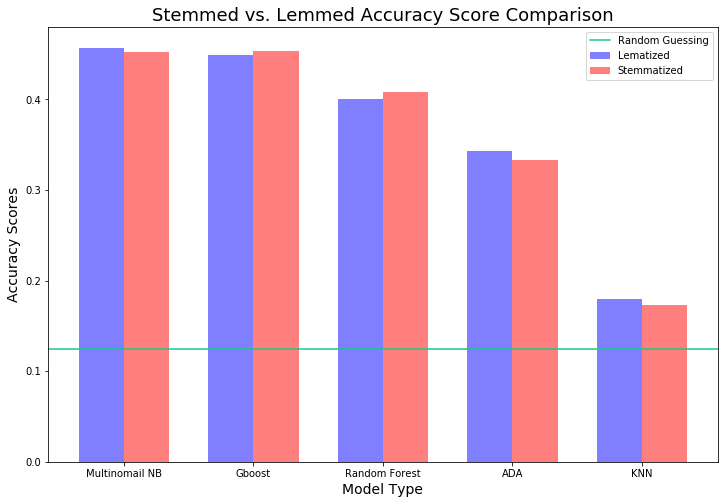

In [81]:
modles_lem = [item[0] for item in lemmed_basic_scores]
accuracy_lem = [item[1] for item in lemmed_basic_scores]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = 5

means_men = (20, 35, 30, 35, 27)
std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)


fig, ax = plt.subplots(figsize = (12, 8))


index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.5
error_config = {'ecolor': '0.3'}

lemmed_bars = ax.bar(index, accuracy_lem, bar_width,
                alpha=opacity, color='b',
                label='Lematized')

stemmed_bars = ax.bar(index + bar_width, accuracy_stem, bar_width,
                alpha=opacity, color='r',
                label='Stemmatized')

ax.set_xlabel('Model Type', fontsize = 14)
ax.set_ylabel('Accuracy Scores', fontsize = 14)
ax.set_title('Stemmed vs. Lemmed Accuracy Score Comparison', fontsize = 18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(modles_lem)

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
ax.legend()


plt.show()


### We decided to pick Lemmatized over Stemmatized and top three models for further optimization

### Next we want to try using PCA to improve performance and reduce dimentionality

In [82]:
tfidf = TfidfVectorizer()
response = tfidf.fit_transform(lemmed_lyrics)

PCA_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())
PCA_df.shape

(7200, 35846)

In [83]:
DATA = response  # this comes from above where you're vectorizing tdif dictionary

non_zero_cols = DATA.nnz / float(DATA.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(DATA.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 66.79833333333333
Percentage of columns containing 0: 0.9981365191839164


In [84]:
PCA_df.head()

,aa,aaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaah,aaaaaaaahhhhhhhhhhhh,aaaaaaaeeeeaaaaeeeeooooo,aaaaaaahhhhhhhh,aaaaaah,aaaaaaiiinnnnntttttttt,aaaaaaooooooouuuuuu,...,zwierza,zwiewn,zwijgen,zwischen,zwo,zwracam,zy,zycia,zyje,zzap
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating Features table and Target table and testing first model

In [85]:
X_pca = PCA_df
y_pca = maybe_df.genre

len(X_pca) == len(y_pca)

True

In [86]:
from sklearn.model_selection import train_test_split  
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=18) 

### Try different PCA values and pick a number that preserves sufficient % of variation

In [ ]:
# from sklearn.decomposition import PCA
# pca_1 = PCA(n_components=500)
# pca_2 = PCA(n_components=1000)
# pca_3 = PCA(n_components=1455)
# pca_4 = PCA(n_components=2000)

# principalComponents = pca_1.fit_transform(X_pca)
# principalComponents = pca_2.fit_transform(X_pca)
# principalComponents = pca_3.fit_transform(X_pca)
# principalComponents = pca_4.fit_transform(X_pca)

# print(np.sum(pca_1.explained_variance_ratio_))
# print(np.sum(pca_2.explained_variance_ratio_))
# print(np.sum(pca_3.explained_variance_ratio_))
# print(np.sum(pca_4.explained_variance_ratio_))

### We will test PCA witn n = 1800 on our top 3 models to see if it helps performance

In [88]:
pipe_NB_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
                     ('clf', GaussianNB())
                    ])

pipe_RF_pca = Pipeline([('pca', PCA(n_components=3000, random_state=18)),
                     ('clf', RandomForestClassifier(n_jobs = -1))
                   ])
                  
pipe_GBoost_pca = Pipeline([('pca', PCA(n_components=1800, random_state=18)),
                     ('clf', GradientBoostingClassifier(learning_rate=0.3))
                    ])


# List of pipelines, List of pipeline names
pipelines = [pipe_NB_pca, pipe_RF_pca, pipe_GBoost_pca]
pipeline_names = ['Multinomial NB', "Random Forest", "Gradient Boost"]

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train_pca, y_train_pca)

# Compare accuracies
PCA_scores = []
for index, val in enumerate(pipelines):
    tup = (pipeline_names[index], val.score(X_test_pca, y_test_pca))
    lemmed_basic_scores.append(tup)
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test_pca, y_test_pca)))

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3000, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None, var_smoothing=1e-09))])
Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3000, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
           ..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=1800, random_state=18,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features=Non...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])
Multinomial NB pipeline test accuracy: 0.149
Random Forest pipeline test accuracy: 0.290
Gradient Boost pipeline test accuracy: 0.423


In [90]:
PCA1800_results = dict(Multinomail_NB = 0.203,
Gradient_boost = 0.422,
Random_forest =0.290)



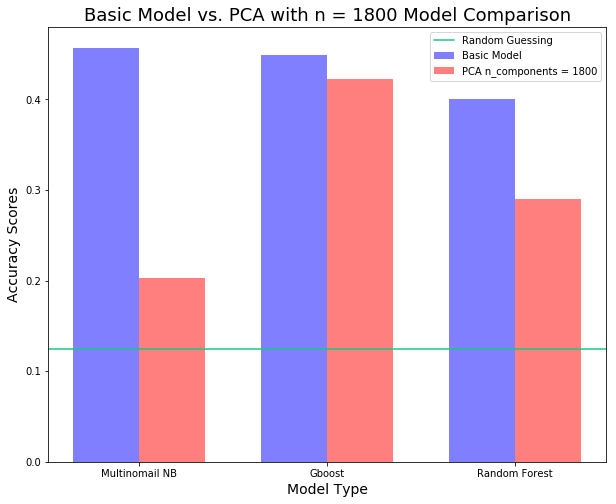

In [91]:
n_groups = 3

basic_mod_name = modles_lem[:3]
basic_mod_acc = accuracy_lem[:3]
pca_models_acc = [item[1] for item in PCA1800_results.items()]

fig, ax = plt.subplots(figsize = (10,8))


index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.5
error_config = {'ecolor': '0.3'}

basic_bars = ax.bar(index, basic_mod_acc, bar_width,
                alpha=opacity, color='b',
                label='Basic Model')

pca_bars = ax.bar(index + bar_width, pca_models_acc , bar_width,
                alpha=opacity, color='r',
                label='PCA n_components = 1800')

ax.set_xlabel('Model Type', fontsize = 14)
ax.set_ylabel('Accuracy Scores', fontsize = 14)
ax.set_title('Basic Model vs. PCA with n = 1800 Model Comparison', fontsize = 18)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(basic_mod_name)

plt.axhline(y=1/len(set(y)), color='#17CA83', linestyle='-', label = "Random Guessing")
ax.legend()
plt.show()

### We decided that it's not worth using PCA for our models because it increases computational time and doesn't really improve performance

## Let's use GridSearch to try to optimize our  top 3 models!

In [92]:
Top3_pipelines = [pipe_NB, pipe_GBoost, pipe_RF]
Top3_pipeline_names = ['Multinomail NB', "Gboost", 'Random Forest']

### Grid Search RandomForest

In [93]:
GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

sorted(GS_pipe_RF.get_params().keys())

rf_param_grid = dict(clf__n_estimators = [10, 30, 100], clf__criterion = ['gini', 'entropy'], 
                    clf__max_depth = [2, 6, 10], clf__min_samples_split = [5, 10],
                    clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

dt_gs_training_score = np.mean(gs_RF.cv_results_['mean_train_score'])
dt_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_RF.best_params_))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Mean Training Score: 41.6%
Mean Testing Score: 41.67%
Best Parameter Combination Found During Grid Search: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}


In [94]:
Grid_RF_metrics = dict(train_score = dt_gs_training_score, test_score = dt_gs_testing_score, best_params = gs_RF.best_params_)
Grid_RF_metrics

{'train_score': 0.416040748177916,
 'test_score': 0.4166666666666667,
 'best_params': {'clf__criterion': 'entropy',
  'clf__max_depth': 10,
  'clf__min_samples_leaf': 3,
  'clf__min_samples_split': 10,
  'clf__n_estimators': 100}}

### GridSearch Gboost

In [95]:
GS_pipe_GB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier())
                    ])
# sorted(GS_pipe_RF.get_params().keys())

GB_params = {
    "clf__learning_rate": [0.2, 0.3],
    "clf__min_samples_split": [5],
    "clf__min_samples_leaf": [6],
    "clf__max_depth":[3],
    "clf__n_estimators":[100, 200]
    }

gs_GB = GridSearchCV(estimator=GS_pipe_GB,
            param_grid=GB_params,
            scoring='accuracy',
            cv=3)

gs_GB.fit(X_train, y_train)

dt_GB_training_score = np.mean(gs_GB.cv_results_['mean_train_score'])
dt_GB_testing_score = gs_GB.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(dt_GB_training_score * 100))
print("Mean Testing Score: {:.4}%".format(dt_GB_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: {}".format(gs_GB.best_params_))

Mean Training Score: 95.22%
Mean Testing Score: 46.39%
Best Parameter Combination Found During Grid Search: {'clf__learning_rate': 0.2, 'clf__max_depth': 3, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [ ]:
Grid_GB_metrics = dict(train_score = dt_GB_training_score, test_score = dt_GB_testing_score, best_params = gs_GB.best_params_)
Grid_GB_metrics

In [ ]:
basic_scores

In [ ]:
final_top3 = [("GradientBoost with GridSearch", Grid_GB_metrics['test_score']), basic_scores[0], ("Random Forest with GridSearch", basic_scores[2][1])]

In [ ]:
final_top3

In [ ]:
top3_model = [item[0] for item in final_top3]
top3_scores = [item[1] for item in final_top3]

plt.figure(figsize=(10,6))
plt.title("Top3 Models Final Performance", color ='#061152' , fontsize = 20)
plt.ylabel("Accuracy Score", color = '#061152', fontsize = 16)
plt.bar(top3_model, top3_scores, color = "#17CA83", label = "Top 3 Models")

plt.axhline(y=1/len(set(y)), color='#AF2138', linestyle='-', label = "Random Guessing")
plt.legend()

plt.show()

In [ ]:
top_mode_df = pd.DataFrame.from_dict(Grid_GB_metrics['best_params'])
top_mode_df

In [ ]:
!pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models

In [ ]:
import random
test = random.sample(stemmed_lyrics, 7000)
lemmed_lyr = [nltk.word_tokenize(doc) for doc in test]

lemmed_lyr
# test
dictionary = gensim.corpora.Dictionary(lemmed_lyr)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in lemmed_lyr]

### Run Topic Classifier using BoW

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=15, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

### Using Topic Classifier Using TF-IDF

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

### WordCloud

In [ ]:
weights = tfidf[bow_corpus[12]]

# Get terms from the dictionary and pair with weights

weights = [(dictionary[pair[0]], pair[1]) for pair in weights]
weights[-35:]



In [ ]:
# !pip install wordcloud
from wordcloud import WordCloud

# Initialize the word cloud

d = {}
for a, x in weights:
    d[a] = x
    
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width = 1024,
    height = 720,
    stopwords=stopwords.words("english")
)

# Generate the cloud

wc.generate_from_frequencies(d)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
d